In [152]:
import itertools
import os
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from skimage import (
    filters,
    segmentation,
    )
from sklearn.preprocessing import StandardScaler

## Visualize Original and Gaussian Filtered Images

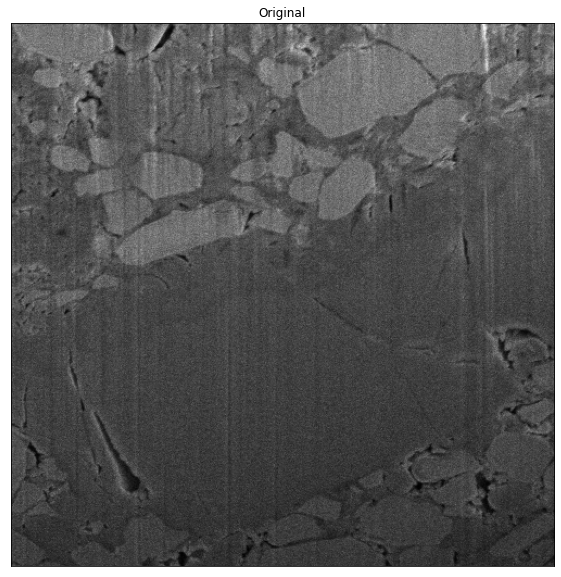

In [153]:
img = plt.imread("unsegmented/000.tif")
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title("Original")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()

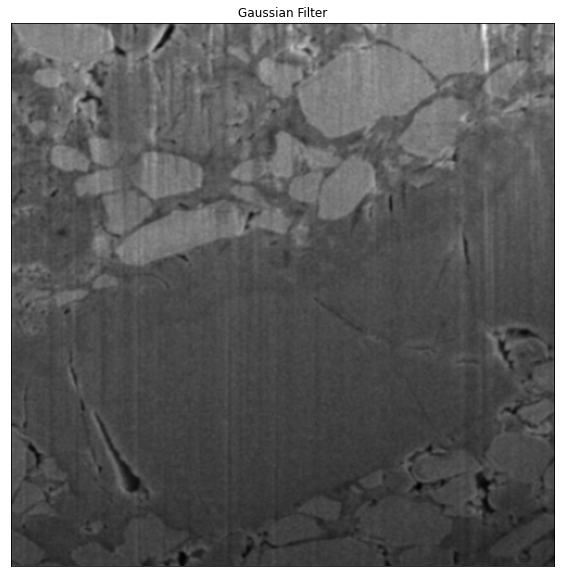

In [154]:
img_gauss = filters.gaussian(img)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_gauss, cmap='gray')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Gaussian Filter")
plt.show()

## Segmentation via Edge Detection
We could try different thresholds with the Meijering filter and then identify clusters for each threshold. For each threshold, we calculate the pixel average per cluster. The best threshold is the on that minimizes the variance of the pixel average per cluster

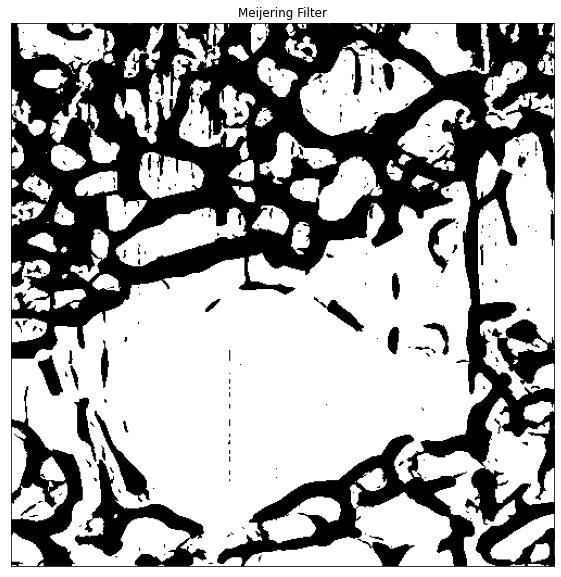

In [155]:
img_meijer = filters.meijering(img_gauss) < 0.1
# img_meijer = filters.gaussian(img_meijer, sigma=0.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_meijer, cmap='gray')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Meijering Filter")
plt.show()

In [156]:
points = set()
for (x, y) in np.argwhere(img_meijer):
    points.add((x, y))
point_ids = np.zeros((len(points), 2))
for idx, point in enumerate(points):
    point_ids[idx, :] = point
points_view = {(v[0], int(v[1])): k for k, v in enumerate(point_ids)}

G = nx.Graph()
for k, v in points_view.items():
    G.add_node(v)
for k in points_view.keys():
    x, y = k
    neighbors = [
        (int(x + 1), y),
        (int(x - 1), y),
        (x, int(y + 1)),
        (x, int(y - 1)),
    ]
    p0 = points_view[k]
    for neighbor in neighbors:
        p = points_view.get(neighbor)
        if p is None:
            continue
        G.add_edge(p0, p)
pieces = nx.connected_components(G)
pieces = [piece for piece in pieces]

### Average of pixel values per connected pixels cluster

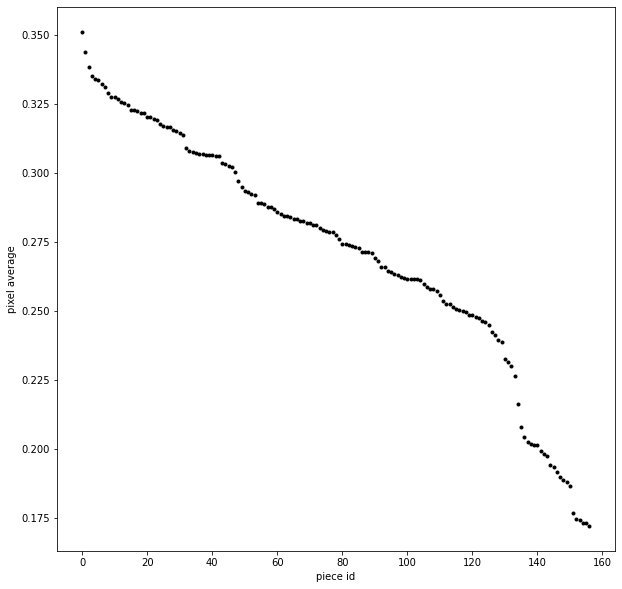

In [157]:
pixel_average = np.zeros(len(pieces)).reshape(-1, 1)
for idx, piece in enumerate(pieces):
    piece_points = np.array([point_ids[p] for p in piece], dtype=np.int32)
    pixel_average[idx] = np.average(img_gauss[piece_points])

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(len(pieces)), sorted(pixel_average.tolist(), reverse=True), '.k')
ax.set_xlabel("piece id")
ax.set_ylabel("pixel average")
plt.show()

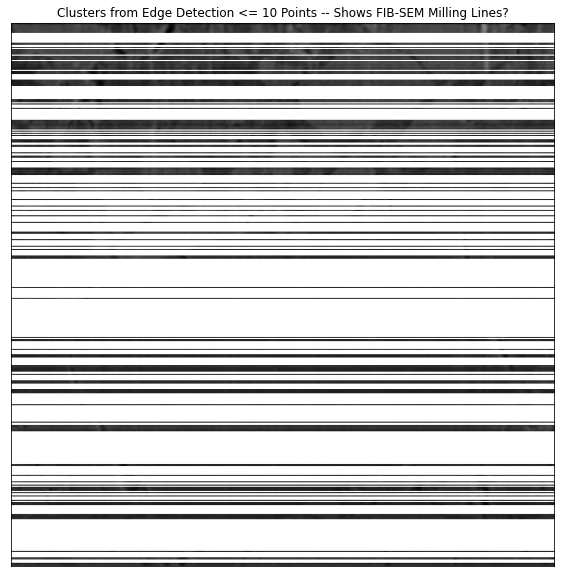

In [158]:
clusters = np.ones(img.shape)
cluster_points = set()
for idx, piece in enumerate(pieces):
    piece_points = np.array([point_ids[p] for p in piece], dtype=np.int32)
    if len(piece_points) > 10:
        continue
    clusters[piece_points] = img_gauss[piece_points] - np.average(img_gauss[piece_points])#)/np.std(img_gauss[piece_points])
new_img = filters.gaussian(clusters)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(clusters, cmap='gray')
ax.set_title("Clusters from Edge Detection <= 10 Points -- Shows FIB-SEM Milling Lines?")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()

In [159]:
plt.imsave("trial.bmp", new_img, cmap='gray')

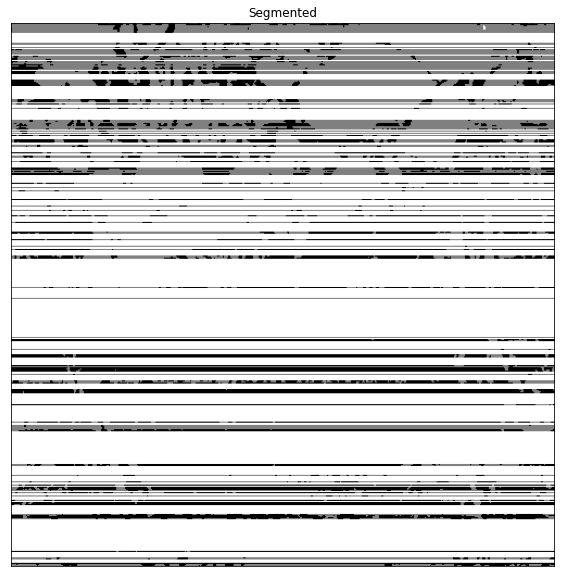

In [160]:
thresholds = filters.threshold_multiotsu(clusters, nbins=3)
img = np.digitize(clusters, bins=thresholds)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title("Segmented")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()